In [1]:
# Cach do os from dir
import os

checklist = os.listdir('component')

print(checklist)
print(type(checklist))

['g_reconstruct', '__init__.py', 'd_scheduling', 'f_assemble', 'a_backend', 'h_analyze', '__pycache__', 'b_benchmark', 'e_mapping', 'c_circuit_cutting']
<class 'list'>


Observable: SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


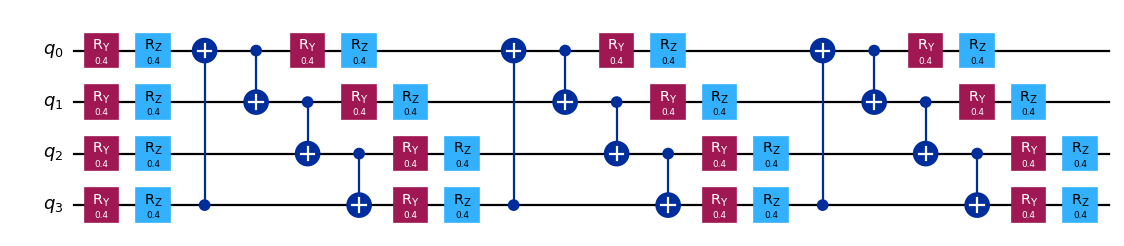

In [2]:
import numpy as np
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, Batch
from qiskit_aer.primitives import EstimatorV2
from qiskit_addon_cutting import (
    cut_gates,
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)
 
circuit = efficient_su2(num_qubits=4, entanglement="circular")
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
 
observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
print(f"Observable: {observable}")
circuit.draw("mpl", scale=0.8)

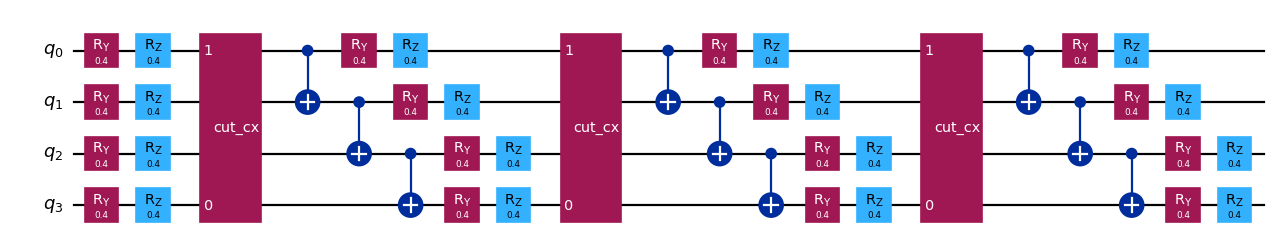

In [3]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]
 
# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)
 
qpd_circuit.draw("mpl", scale=0.8)

In [4]:
# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)
 
# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = pass_manager.run(subexperiments)
 
# Set up the Qiskit Runtime Sampler primitive, submit the subexperiments, and retrieve the results
sampler = SamplerV2(backend)
job = sampler.run(isa_subexperiments, shots=4096 * 3)
results = job.result()
 
 
# Reconstruct the results
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    observable.paulis,
)
 
# Apply the coefficients of the original observable
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
 
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(circuit, observable, [0.4] * len(circuit.parameters))])
    .result()[0]
    .data.evs
)
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a03f9bd67d0>>
Traceback (most recent call last):
  File "/home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a03f9bd67d0>>
Traceback (most recent call last):
  File "/home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a03f9bd67d0>>    
def _clean_thread_parent_frames(Traceback (most recent call last):

  File "/home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, i

QiskitError: 'Keyboard interrupt in parallel_map.'

In [5]:
import qiskit
from qiskit_aer.primitives import SamplerV2

# Generate 3-qubit GHZ state
circ = qiskit.QuantumCircuit(3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure_all()

# Construct an ideal simulator with SamplerV2
sampler = SamplerV2()
job = sampler.run([circ], shots=128)

# Perform an ideal simulation
result_ideal = job.result()
counts_ideal = result_ideal[0].data.meas.get_counts()
print('Counts(ideal):', counts_ideal)

Counts(ideal): {'111': 61, '000': 67}


# Test AerSimulators

In [6]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

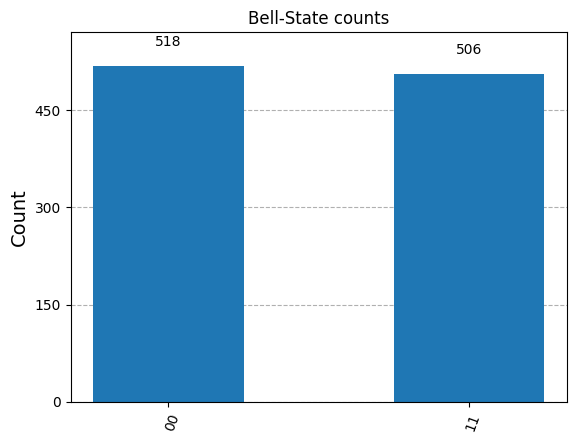

In [7]:
simulator = AerSimulator()
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = AerSimulator()
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [8]:
# Run and get memory
result = simulator.run(circ, shots=10, memory=True).result()
memory = result.get_memory(circ)
print(memory)

['00', '00', '00', '00', '11', '00', '00', '11', '00', '11']


In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import PauliList
from qiskit_ibm_runtime.utils.embeddings import Embedding
from qiskit_ibm_runtime.utils.noise_learner_result import LayerError, PauliLindbladError
 
# A five-qubit 1-D embedding with nearest neighbouring connectivity
coordinates1 = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
coupling_map1 = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
embedding1 = Embedding(coordinates1, coupling_map1)
 
# A six-qubit horseshoe-shaped embedding with nearest neighbouring connectivity
coordinates2 = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
coupling_map2 = [(0, 1), (1, 2), (0, 3), (3, 4), (4, 5)]
embedding2 = Embedding(coordinates2, coupling_map2)
 
# A LayerError object
circuit = QuantumCircuit(4)
qubits = [1, 2, 3, 4]
generators = PauliList(["IIIX", "IIXI", "IXII", "YIII", "ZIII", "XXII", "ZZII"])
rates = [0.01, 0.01, 0.01, 0.005, 0.02, 0.01, 0.01]
error = PauliLindbladError(generators, rates)
layer_error = LayerError(circuit, qubits, error)
 
# Draw the layer error on embedding1
layer_error.draw_map(embedding1)
 
# Draw the layer error on embedding2
layer_error.draw_map(embedding2)

TypeError: SamplerV2.__init__() got an unexpected keyword argument 'backend'